## Análise Fatorial e PCA
### MBA em Data Science e Analytics USP ESALQ

**Prof Dr.** Wilson Tarantin Junior

**Aluna:** Luiza Batista Laquini

**Turma:** DSA 2024-1

### Bibliotecas e configurações

In [29]:
import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

#import plotly.io as pio
#pio.renderers.default='browser'

import warnings
warnings.filterwarnings("ignore")

**Objetivo:** Extraír fatores que capturem o preço de venda das casas.

### Visualização dos dados

In [30]:
casas = pd.read_excel("preco_casas.xlsx")
# Fonte: adaptado de https://www.kaggle.com/datasets/elakiricoder/jiffs-house-price-prediction-dataset

casas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4954 entries, 0 to 4953
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   land_size_sqm               4954 non-null   int64  
 1   house_size_sqm              4954 non-null   int64  
 2   no_of_rooms                 4954 non-null   int64  
 3   no_of_bathrooms             4954 non-null   int64  
 4   distance_to_school          4954 non-null   float64
 5   house_age                   4954 non-null   int64  
 6   distance_to_supermarket_km  4954 non-null   float64
 7   crime_rate_index            4954 non-null   float64
 8   property_value              4954 non-null   int64  
dtypes: float64(3), int64(6)
memory usage: 348.5 KB


In [31]:
casas.head(3)

,land_size_sqm,house_size_sqm,no_of_rooms,no_of_bathrooms,distance_to_school,house_age,distance_to_supermarket_km,crime_rate_index,property_value
0,201,177,3,1,3.3,10,6.8,0.90,165432
1,196,182,4,3,1.2,11,4.1,1.42,187043
2,198,182,4,4,5.9,20,2.1,4.12,148658


In [32]:
# Estatísticas descritivas
tab_desc = casas.describe()
tab_desc = tab_desc.T
tab_desc

,count,mean,std,min,25%,50%,75%,max
land_size_sqm,4954.0,250.131409,103.131939,100.00,180.00,235.00,295.00,796.00
house_size_sqm,4954.0,231.250908,94.571642,85.00,165.00,217.50,274.00,760.00
no_of_rooms,4954.0,3.788252,1.585371,1.00,3.00,4.00,5.00,8.00
no_of_bathrooms,4954.0,3.199839,1.602300,1.00,2.00,3.00,4.00,9.00
distance_to_school,4954.0,3.454219,2.007358,0.10,1.70,3.40,5.20,6.90
house_age,4954.0,11.444691,6.356991,1.00,6.00,11.00,17.00,22.00
distance_to_supermarket_km,4954.0,3.508639,1.991266,0.10,1.80,3.50,5.30,6.90
crime_rate_index,4954.0,2.986110,1.737742,0.01,1.47,3.02,4.49,5.99
property_value,4954.0,201974.738999,90031.882219,32622.00,136777.00,194515.50,246590.00,692086.00


### Correlação Linear

In [33]:
corr = casas.corr()

# Mapa de calor
fig = go.Figure()
fig.add_trace(
    go.Heatmap(
        x = corr.columns,
        y = corr.index,
        z = np.array(corr),
        text=corr.values,
        texttemplate='%{text:.3f}',
        colorscale='viridis'))
fig.update_layout(
    height = 750,
    width = 750,
    yaxis=dict(autorange="reversed"))
fig.show()

### Teste de Esfericidade de Bartlett

Usado para investigar a adequação global da análise fatorial. Compara a matriz de correlações com a matriz identidade de mesma dimensão e espera-se que tais matrizes sejam diferentes para que a análise seja aplicável.

Interpretação dos resultados:

- Qui²: Um valor alto de qui-quadrado indica que a hipótese nula (de que a matriz de correlação é uma matriz identidade) é improvável. 
- p-valor: chance da hipótese nula ser verdadeira (lembrando que o objetivo é rejeitar a hipótese nula para que o modelo seja aplicável)

In [34]:
# Deixando a coluna dos preços de fora do PCA
casas_pca = casas.drop(columns=['property_value'])

# Teste de esfericidade
bartlett, p_value = calculate_bartlett_sphericity(casas_pca)

print(f'QuiÂ² Bartlett: {round(bartlett, 2)}')
print(f'p-valor: {round(p_value, 4)}')

QuiÂ² Bartlett: 31857.46
p-valor: 0.0


Os resultados do teste de esfericidade de Bartlett fornecem evidência forte de que as correlações entre as variáveis são significativas e, portanto, a análise fatorial é adequada para o conjunto de dados.

### PCA

In [35]:
fa = FactorAnalyzer(n_factors=8, method='principal', rotation=None).fit(casas_pca)

autovalores = fa.get_eigenvalues()[0]
print(autovalores)

[3.44078793 1.01989592 1.01155913 0.99164638 0.97675882 0.42231466
 0.128448   0.00858917]


In [36]:
# Soma dos autovalores
round(autovalores.sum(), 2)

8.0

**Critério de Kaiser (raiz latente)**

Temos 3 autovalores maiores do que 1<br>
Vamos parametrizar a função para a extração de 3 fatores!

In [37]:
fa = FactorAnalyzer(n_factors=3, method='principal', rotation=None).fit(casas_pca)

In [38]:
# Eigenvalues, varâncias e varâncias acumuladas
autovalores_fatores = fa.get_factor_variance()

tabela_eigen = pd.DataFrame(autovalores_fatores)
tabela_eigen.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_eigen.columns)]
tabela_eigen.index = ['Autovalor','Variância', 'Variância Acumulada']
tabela_eigen = tabela_eigen.T

print(tabela_eigen)

         Autovalor  Variância  Variância Acumulada
Fator 1   3.440788   0.430098             0.430098
Fator 2   1.019896   0.127487             0.557585
Fator 3   1.011559   0.126445             0.684030


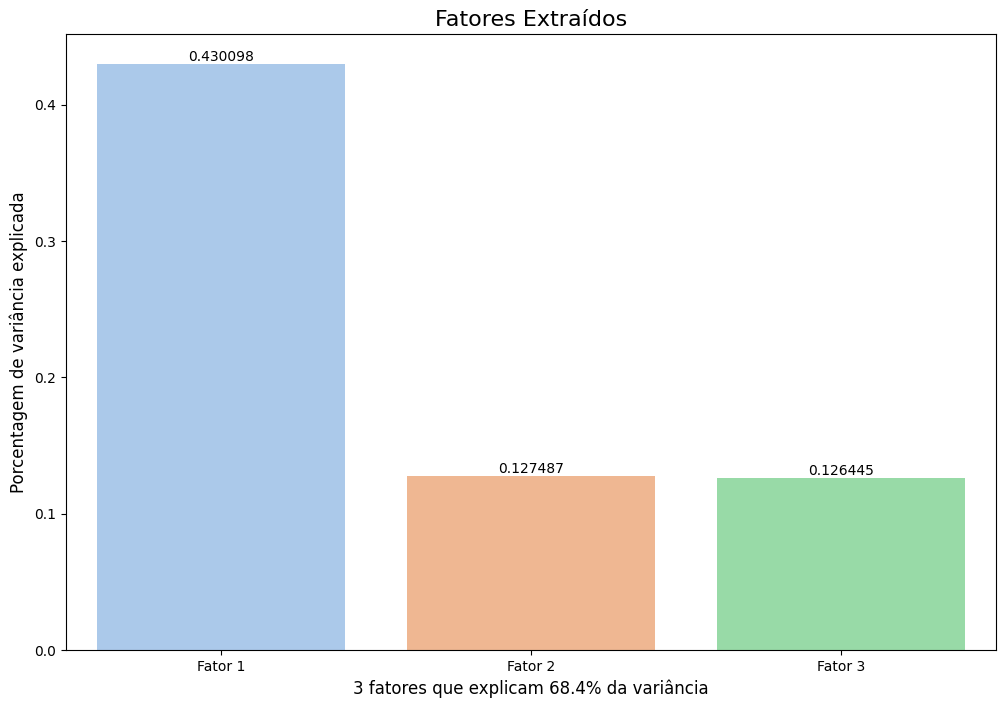

In [39]:
# Gráfico da variânncia acumulada dos componentes principais
plt.figure(figsize=(12,8))
ax = sns.barplot(x=tabela_eigen.index, y=tabela_eigen['Variância'], data=tabela_eigen, palette='pastel')
ax.bar_label(ax.containers[0])
plt.title("Fatores Extraídos", fontsize=16)
plt.xlabel(f"{tabela_eigen.shape[0]} fatores que explicam {round(tabela_eigen['Variância'].sum()*100,2)}% da variância", fontsize=12)
plt.ylabel("Porcentagem de variância explicada", fontsize=12)
plt.show()

#### Cargas Fatoriais

In [40]:
# Cargas Fatoriais
cargas_fatoriais = fa.loadings_

tabela_cargas = pd.DataFrame(cargas_fatoriais)
tabela_cargas.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_cargas.columns)]
tabela_cargas.index = casas_pca.columns

print(tabela_cargas)

                             Fator 1   Fator 2   Fator 3
land_size_sqm               0.969318  0.000670  0.003416
house_size_sqm              0.967866 -0.000800  0.005045
no_of_rooms                 0.948705 -0.002536  0.002939
no_of_bathrooms             0.814810 -0.002453 -0.002870
distance_to_school         -0.013787  0.349991  0.642441
house_age                   0.007448  0.080374  0.692606
distance_to_supermarket_km -0.000987  0.720297 -0.113461
crime_rate_index            0.015520  0.610001 -0.325882


In [41]:
# Analisando as cargas fatoriais em cada fator extraído
tabela_cargas_graph = tabela_cargas.reset_index()
tabela_cargas_graph = tabela_cargas_graph.melt(id_vars='index')
tabela_cargas_graph

,index,variable,value
0,land_size_sqm,Fator 1,0.969318
1,house_size_sqm,Fator 1,0.967866
2,no_of_rooms,Fator 1,0.948705
3,no_of_bathrooms,Fator 1,0.814810
4,distance_to_school,Fator 1,-0.013787
5,house_age,Fator 1,0.007448
6,distance_to_supermarket_km,Fator 1,-0.000987
7,crime_rate_index,Fator 1,0.015520
8,land_size_sqm,Fator 2,0.000670
9,house_size_sqm,Fator 2,-0.000800


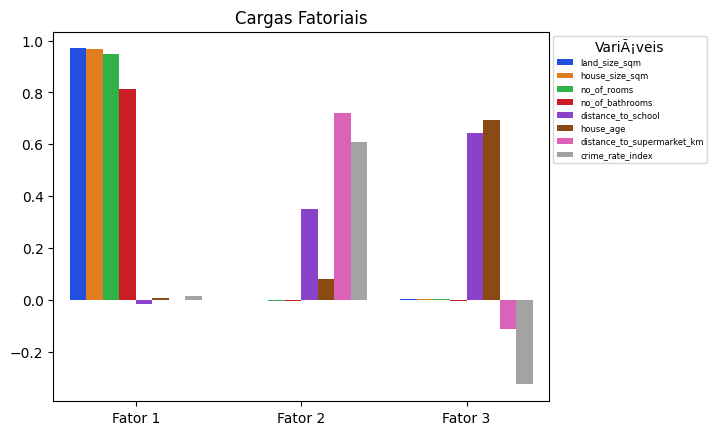

In [42]:
# Visualizando em gráfico
sns.barplot(data=tabela_cargas_graph, x='variable', y='value', hue='index', palette='bright')
plt.legend(title='VariÃ¡veis', bbox_to_anchor=(1,1), fontsize = '6')
plt.title('Cargas Fatoriais', fontsize='12')
plt.xlabel(xlabel=None)
plt.ylabel(ylabel=None)
plt.show()

#### Comunalidades

In [43]:
# Comunalidades
comunalidades = fa.get_communalities()

tabela_comunalidades = pd.DataFrame(comunalidades)
tabela_comunalidades.columns = ['Comunalidades']
tabela_comunalidades.index = casas_pca.columns

print(tabela_comunalidades)

                            Comunalidades
land_size_sqm                    0.939590
house_size_sqm                   0.936791
no_of_rooms                      0.900057
no_of_bathrooms                  0.663930
distance_to_school               0.535414
house_age                        0.486218
distance_to_supermarket_km       0.531702
crime_rate_index                 0.478541


In [44]:
# % Extração dos fatores para as observações do banco de dados
fatores = pd.DataFrame(fa.transform(casas_pca))
fatores.columns =  [f"Fator {i+1}" for i, v in enumerate(fatores.columns)]

# Adicionando os fatores ao banco de dados
casas = pd.concat([casas.reset_index(drop=True), fatores], axis=1)

#### Scores Fatoriais 

In [45]:
# Scores fatoriais
scores = fa.weights_

tabela_scores = pd.DataFrame(scores)
tabela_scores.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_scores.columns)]
tabela_scores.index = casas_pca.columns

print(tabela_scores)

                             Fator 1   Fator 2   Fator 3
land_size_sqm               0.281714  0.000657  0.003377
house_size_sqm              0.281292 -0.000784  0.004987
no_of_rooms                 0.275723 -0.002487  0.002906
no_of_bathrooms             0.236809 -0.002405 -0.002837
distance_to_school         -0.004007  0.343163  0.635100
house_age                   0.002165  0.078806  0.684691
distance_to_supermarket_km -0.000287  0.706245 -0.112164
crime_rate_index            0.004510  0.598101 -0.322158


In [46]:
# Analisando os scores fatoriais em cada fator extraí­do
tabela_scores_graph = tabela_scores.reset_index()
tabela_scores_graph = tabela_scores_graph.melt(id_vars='index')
tabela_scores_graph

,index,variable,value
0,land_size_sqm,Fator 1,0.281714
1,house_size_sqm,Fator 1,0.281292
2,no_of_rooms,Fator 1,0.275723
3,no_of_bathrooms,Fator 1,0.236809
4,distance_to_school,Fator 1,-0.004007
5,house_age,Fator 1,0.002165
6,distance_to_supermarket_km,Fator 1,-0.000287
7,crime_rate_index,Fator 1,0.004510
8,land_size_sqm,Fator 2,0.000657
9,house_size_sqm,Fator 2,-0.000784


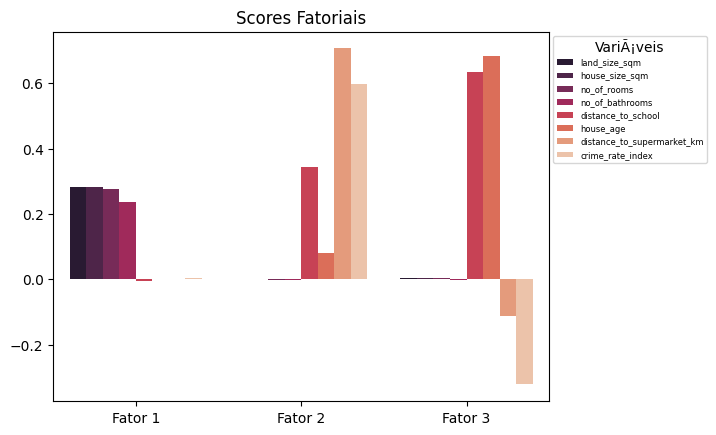

In [47]:
# Visualizando em gráfico
sns.barplot(data=tabela_scores_graph, x='variable', y='value', hue='index', palette='rocket')
plt.legend(title='VariÃ¡veis', bbox_to_anchor=(1,1), fontsize = '6')
plt.title('Scores Fatoriais', fontsize='12')
plt.xlabel(xlabel=None)
plt.ylabel(ylabel=None)
plt.show()

In [48]:
# Vamos consolidar os 3 fatores em uma medida única (soma ponderada)
casas['Ranking'] = 0

for index, item in enumerate(list(tabela_eigen.index)):
    variancia = tabela_eigen.loc[item]['Variância']
    casas['Ranking'] = casas['Ranking'] + casas[tabela_eigen.index[index]]*variancia
    
# Visualizando se os preços se alinham às características representadas nos fatores
pg.rcorr(casas[['Ranking', 'property_value']], 
         method = 'pearson', upper = 'pval', 
         decimals = 4, 
         pval_stars = {0.01: '***', 0.05: '**', 0.10: '*'})

,Ranking,property_value
Ranking,-,***
property_value,0.8494,-
